### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import cv2, os, re
import matplotlib.pyplot as plt
import imutils

from tqdm import tqdm
from imutils.object_detection import non_max_suppression

from tensorflow.keras.models import load_model

/Users/chohi/project/ai/CapstonProject/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Utitilty Functions

In [2]:
def find_regions(image, method):

    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)

    if method == 'fast':
        ss.switchToSelectiveSearchFast()
    else:
        ss.switchToSelectiveSearchQuality()

    rects = ss.process()
    boxes = []
    for (x,y,w,h) in rects:

        boxes.append([x,y,w,h])
        pass

    return boxes
    pass

In [3]:
scene_path = './ships-in-satellite-imagery/scenes/scenes'

def load_scenes():

    scenes = []
    dirfiles = os.listdir(scene_path)
    dirfiles = sorted(dirfiles)
    for file in dirfiles:

        print(os.path.join(scene_path, file))
        scene = cv2.imread(os.path.join(scene_path, file))
        scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
        scenes.append(scene)
        pass

    return scenes
    pass

In [4]:
scenes = load_scenes()

./ships-in-satellite-imagery/scenes/scenes/lb_1.png
./ships-in-satellite-imagery/scenes/scenes/lb_2.png
./ships-in-satellite-imagery/scenes/scenes/lb_3.png
./ships-in-satellite-imagery/scenes/scenes/lb_4.png
./ships-in-satellite-imagery/scenes/scenes/sfbay_1.png
./ships-in-satellite-imagery/scenes/scenes/sfbay_2.png
./ships-in-satellite-imagery/scenes/scenes/sfbay_3.png
./ships-in-satellite-imagery/scenes/scenes/sfbay_4.png


### Finding ROIs

In [ ]:
%%time
method = "fast"

boxes = []

for scene in scenes:

    box_in_scene = find_regions(scene, method)
    boxes.append(box_in_scene)
    pass

### Loading Saved Model

In [6]:
model = load_model('ship-model.h5')

model.summary()

Model: "Feature_Extraction_and_FC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 58, 58, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 29, 29, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 29, 29, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2A_branch2a (Conv2D)       │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2A_branch2a                  │ (None, 29, 29, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3A_branch2a (Conv2D)       │ (None, 7, 7, 32)       │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3A_branch2a                  │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4A_branch2a (Conv2D)       │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4A_branch2a                  │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 62,532 (244.27 KB)

 Trainable params: 62,242 (243.13 KB)

 Non-trainable params: 288 (1.12 KB)

 Optimizer params: 2 (12.00 B)

### Predicting the ROIs

In [7]:
%%time

rois, locs = [], []
images = []
for i,scene in tqdm(enumerate(scenes)):

    (H, W) = scene.shape[:2]
    region, loc = [],[]
    for (x,y,w,h) in boxes[i]:

        if w/float(W) > 0.10 and h/float(H) > 0.10:
            continue

        roi = scene[y:y+h,x:x+w]
        roi = cv2.cvtColor(roi,cv2.COLOR_BGR2RGB)
        roi = cv2.resize(roi, (48,48))

        rois.append(roi)
        locs.append((x,y,x+w,y+h))
        pass

    preds = model.predict(np.array(rois,dtype=np.float32))
    preds = np.argmax(preds, axis=1)

    img = scene.copy()
    for (i,label) in enumerate(preds):

        if label == 1:
            (startX,startY,endX,endY) = locs[i]
            cv2.rectangle(img,(startX,startY),(endX,endY),(0,255,0),2)
        pass

    images.append(img)
    del rois[:]
    del locs[:]
    pass

0it [00:00, ?it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


1it [00:01,  1.14s/it]

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


2it [00:01,  1.25it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


3it [00:03,  1.06s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


4it [00:04,  1.02s/it]

400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


5it [00:05,  1.26s/it]

314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


6it [00:07,  1.29s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


7it [00:08,  1.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


8it [00:08,  1.06s/it]

CPU times: user 26.9 s, sys: 4.92 s, total: 31.8 s
Wall time: 8.54 s


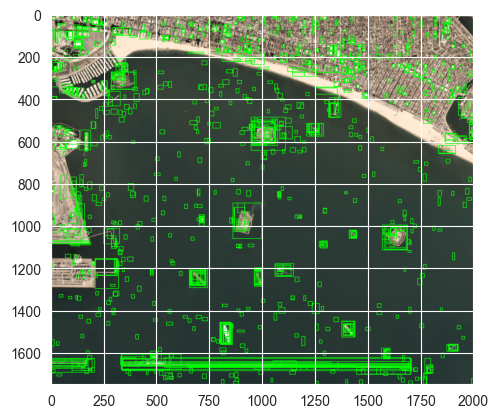

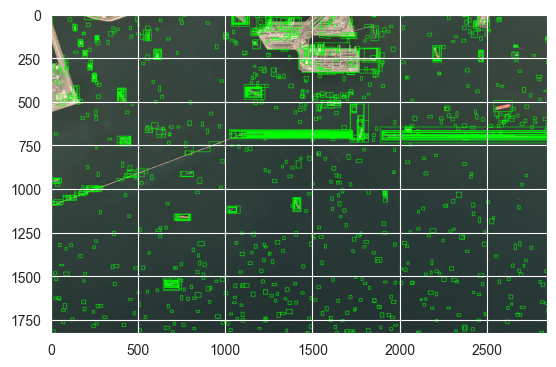

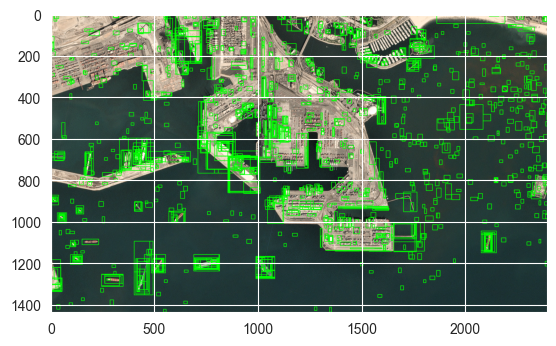

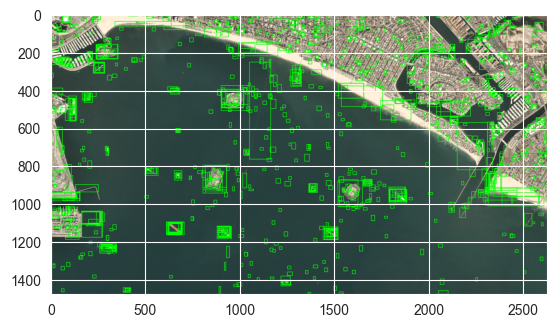

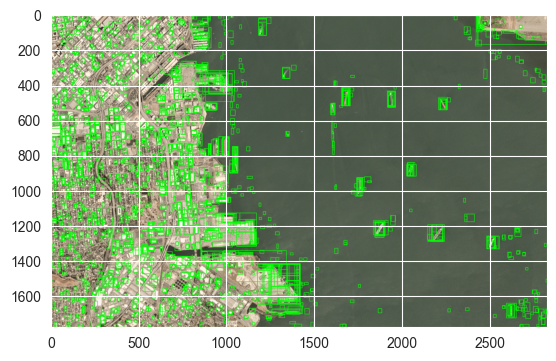

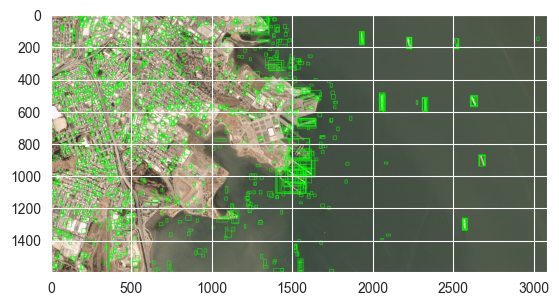

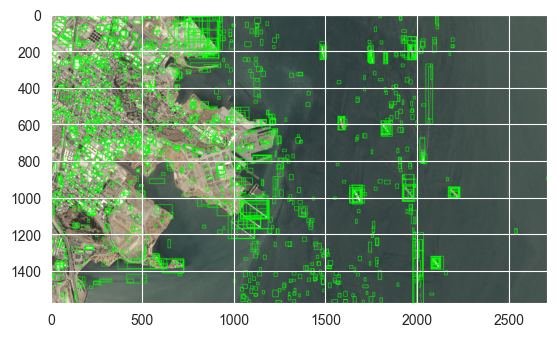

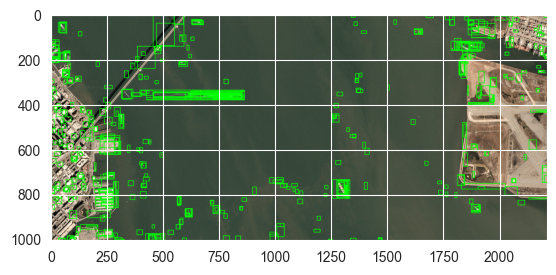

In [10]:
for image in images:

    plt.imshow(image)
    plt.show()